In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.cloud import bigquery
import pandas_gbq
import seaborn as sns

In [6]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'crypto-valuation-490918052e31.json'

### Supplementary Data

In [79]:
# Gold Import
df_gold = pd.read_csv('Gold Futures Historical Data.csv', usecols=['Date','Price'])
df_gold = df_gold.rename(columns={'Price':'Gold'})
df_gold['Gold'] = df_gold['Gold'].str.replace(',','').astype('float')

,Date,Price
1424,07/06/2018,"1,255.80"
1425,07/05/2018,"1,261.70"
1426,07/04/2018,"1,258.80"
1427,07/03/2018,"1,253.50"
1428,07/02/2018,"1,241.70"


In [80]:
# S&P500 Import
df_sp500 = pd.read_csv('S&P 500 Historical Data.csv', usecols=['Date','Price'])
df_sp500 = df_sp500.rename(columns={'Price':'SP500'})
df_sp500['SP500'] = df_sp500['SP500'].str.replace(',','').astype('float') 
df_supplementary = pd.merge(df_supplementary, df_sp500, how='inner',on='Date')

,Date,Price
1379,07/09/2018,"2,784.17"
1380,07/06/2018,"2,759.82"
1381,07/05/2018,"2,736.61"
1382,07/03/2018,"2,713.22"
1383,07/02/2018,"2,726.71"


In [81]:
# NASDAQ Import
df_nasdaq = pd.read_csv('Nasdaq 100 Historical Data.csv', usecols=['Date','Price'])
df_nasdaq = df_nasdaq.rename(columns={'Price':'Nasdaq'})
df_nasdaq['Nasdaq'] = df_nasdaq['Nasdaq'].str.replace(',','').astype('float')
df_supplementary = pd.merge(df_gold, df_nasdaq, how='inner',on='Date')

,Date,Price
1379,07/09/2018,"7,276.00"
1380,07/06/2018,"7,207.33"
1381,07/05/2018,"7,101.05"
1382,07/03/2018,"7,014.55"
1383,07/02/2018,"7,097.82"


In [82]:
# US 10 Year Bond
df_usbond = pd.read_csv('United States 10-Year Bond Yield Historical Data.csv',usecols=['Date','Price'])
df_usbond = df_usbond.rename(columns={'Price':'US_Bond'})
df_supplementary = pd.merge(df_supplementary, df_usbond, how='inner',on='Date')

,Date,Price
0,12/29/2023,3.866
1,12/28/2023,3.846
2,12/27/2023,3.789
3,12/26/2023,3.897
4,12/25/2023,3.902


In [89]:
df_supplementary['Date'] = pd.to_datetime(df_supplementary['Date'], format='%m/%d/%Y')
df_supplementary = df_supplementary.sort_values(by='Date')
df_supplementary = df_supplementary.reset_index()
df_supplementary = df_supplementary.drop(['index'], axis=1)

In [90]:
df_supplementary.to_csv('supplementary_financial_data.csv', index=False)

### Crypto Price Data

In [95]:
df_bitcoin = pd.read_csv('Bitcoin Historical Data.csv', usecols=['Date','Price'])
df_bitcoin = df_bitcoin.rename(columns={'Price':'Bitcoin'})
df_bitcoin['Bitcoin'] = df_bitcoin['Bitcoin'].str.replace(',','').astype('float')
df_crypto = df_bitcoin
df_crypto.head()

,Date,Bitcoin
0,12/31/2023,42272.5
1,12/30/2023,42136.7
2,12/29/2023,42072.4
3,12/28/2023,42581.1
4,12/27/2023,43446.5


In [96]:
crypto_list = ['Ethereum','Cardano','XRP','Dogecoin']

for crypto in crypto_list:
    file_name = crypto + " Historical Data.csv"

    temp_df = pd.read_csv(file_name, usecols = ['Date','Price'])
    
    if crypto == 'Ethereum': 
        temp_df['Price'] = temp_df['Price'].str.replace(',','')
    
    temp_df = temp_df.rename(columns={'Price':crypto})
    temp_df[crypto] = temp_df[crypto].astype('float')
    df_crypto = pd.merge(df_crypto, temp_df, how='inner',on='Date')


In [98]:
df_crypto.shape

(2010, 6)

In [100]:
df_crypto['Date'] = pd.to_datetime(df_crypto['Date'], format='%m/%d/%Y')
df_crypto.dtypes

Date        datetime64[ns]
Bitcoin            float64
Ethereum           float64
Cardano            float64
XRP                float64
Dogecoin           float64
dtype: object

In [101]:
df_crypto = df_crypto.sort_values(by='Date')
df_crypto = df_crypto.reset_index()
df_crypto = df_crypto.drop(['index'], axis=1)


In [102]:
df_crypto.head()

,Date,Bitcoin,Ethereum,Cardano,XRP,Dogecoin
0,2018-07-01,6366.8,452.57,0.1421,0.46226,0.002536
1,2018-07-02,6619.5,475.70,0.1544,0.49005,0.002735
2,2018-07-03,6513.5,461.89,0.1498,0.48516,0.002655
3,2018-07-04,6598.4,467.52,0.1514,0.49194,0.002688
4,2018-07-05,6546.5,468.47,0.1475,0.47779,0.002614


<AxesSubplot:>

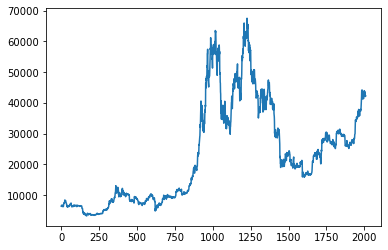

In [103]:
df_crypto['Bitcoin'].plot()

In [104]:
df_crypto.to_csv('crypto_price_data.csv', index=False)

### Bitcoin Blockchain Data

In [13]:
client = bigquery.Client()

In [20]:
# Extract Average Transaction Value and Average Fee per day with Daily Transaction Count
sql_query = '''
SELECT DATE(block_timestamp) as date_day,
   COUNT(*) as transactions_count,
   ROUND(AVG(input_value),2) as average_transaction_value,
   ROUND(AVG(fee),2) as average_fee
 FROM `bigquery-public-data.crypto_bitcoin.transactions` 
 WHERE block_timestamp_month BETWEEN "2018-07-01" AND "2023-12-31"
 GROUP BY DATE(block_timestamp)
 '''
btc_data = pandas_gbq.read_gbq(sql_query, project_id='crypto-valuation')

In [36]:
# Count Unique Addresses sending bitcoin each day
sql_query = f'''
    SELECT 
        COUNT(DISTINCT(ARRAY_TO_STRING(addresses," "))) AS address_count,
        DATE(block_timestamp) as date_day
    FROM `bigquery-public-data.crypto_bitcoin.inputs`
    WHERE DATE(block_timestamp) BETWEEN '2018-07-01' AND LAST_DAY('2023-12-01',month)
    GROUP BY DATE(block_timestamp)
    '''

btc_address_data = pandas_gbq.read_gbq(sql_query, project_id='crypto-valuation')

Downloading:   3%|███                                                                                             |
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████|


,address_str,date_day
0,742796,2022-10-26
1,580209,2022-08-06
2,542598,2022-08-20
3,565059,2021-09-11
4,482756,2019-12-02


In [44]:
bitcoin_df = pd.merge(btc_data, btc_address_data, how='left', on='date_day')
bitcoin_df.head()

,date_day,transactions_count,average_transaction_value,average_fee,address_str
0,2022-04-25,277417,2915891765.230000000,4620.820000000,661219
1,2021-09-12,192691,2329416773.890000000,4445.430000000,425250
2,2022-04-17,207324,1612003968.010000000,2576.470000000,451184
3,2018-10-08,248041,334094260.180000000,6771.460000000,449776
4,2021-01-07,401744,684829820.020000000,30345.880000000,738186


In [45]:
bitcoin_df.to_csv('bitcoin_ledger_data.csv', index=False)

### EDA

In [111]:
df_crypto = pd.read_csv('crypto_price_data.csv')
df_crypto['Date'] = pd.to_datetime(df_crypto['Date'])
df_crypto.head()

,Date,Bitcoin,Ethereum,Cardano,XRP,Dogecoin
0,2018-07-01,6366.8,452.57,0.1421,0.46226,0.002536
1,2018-07-02,6619.5,475.70,0.1544,0.49005,0.002735
2,2018-07-03,6513.5,461.89,0.1498,0.48516,0.002655
3,2018-07-04,6598.4,467.52,0.1514,0.49194,0.002688
4,2018-07-05,6546.5,468.47,0.1475,0.47779,0.002614


In [112]:
df_supplementary = pd.read_csv('supplementary_financial_data.csv')
df_supplementary['Date'] = pd.to_datetime(df_supplementary['Date'], format='%Y-%m-%d')
df_supplementary.head()

,Date,Gold,Nasdaq,SP500,US_Bond
0,2018-07-02,1241.7,7097.82,2726.71,2.871
1,2018-07-03,1253.5,7014.55,2713.22,2.833
2,2018-07-05,1261.7,7101.05,2736.61,2.833
3,2018-07-06,1255.8,7207.33,2759.82,2.824
4,2018-07-09,1259.6,7276.00,2784.17,2.858


In [113]:
df_crypto = pd.merge(df_crypto, df_supplementary, how='left',on='Date')
df_crypto = df_crypto.bfill()
df_crypto.head()

,Date,Bitcoin,Ethereum,Cardano,XRP,Dogecoin,Gold,Nasdaq,SP500,US_Bond
0,2018-07-01,6366.8,452.57,0.1421,0.46226,0.002536,1241.7,7097.82,2726.71,2.871
1,2018-07-02,6619.5,475.70,0.1544,0.49005,0.002735,1241.7,7097.82,2726.71,2.871
2,2018-07-03,6513.5,461.89,0.1498,0.48516,0.002655,1253.5,7014.55,2713.22,2.833
3,2018-07-04,6598.4,467.52,0.1514,0.49194,0.002688,1261.7,7101.05,2736.61,2.833
4,2018-07-05,6546.5,468.47,0.1475,0.47779,0.002614,1261.7,7101.05,2736.61,2.833


In [114]:
df_crypto.corr()

,Bitcoin,Ethereum,Cardano,XRP,Dogecoin,Gold,Nasdaq,SP500,US_Bond
Bitcoin,1.000000,0.926025,0.848394,0.815437,0.766801,0.607827,0.860038,0.856357,0.004375
Ethereum,0.926025,1.000000,0.868215,0.836929,0.839706,0.583727,0.856503,0.887593,0.114513
Cardano,0.848394,0.868215,1.000000,0.858850,0.873735,0.359583,0.667262,0.676838,-0.176282
XRP,0.815437,0.836929,0.858850,1.000000,0.869015,0.306412,0.634551,0.654378,0.020628
Dogecoin,0.766801,0.839706,0.873735,0.869015,1.000000,0.410650,0.650159,0.684862,-0.027339
Gold,0.607827,0.583727,0.359583,0.306412,0.410650,1.000000,0.844384,0.793567,0.039614
Nasdaq,0.860038,0.856503,0.667262,0.634551,0.650159,0.844384,1.000000,0.975528,0.144881
SP500,0.856357,0.887593,0.676838,0.654378,0.684862,0.793567,0.975528,1.000000,0.260642
US_Bond,0.004375,0.114513,-0.176282,0.020628,-0.027339,0.039614,0.144881,0.260642,1.000000


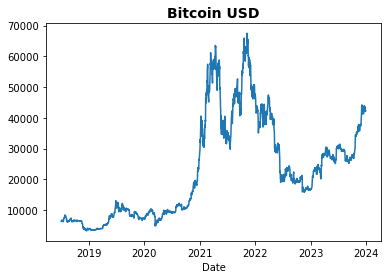

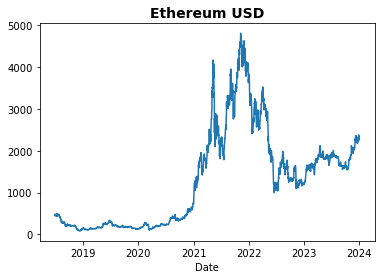

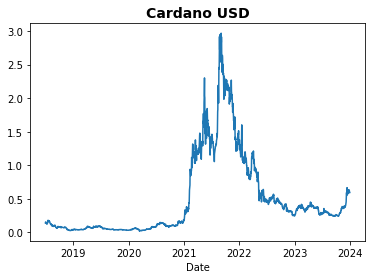

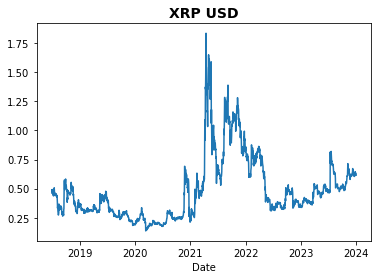

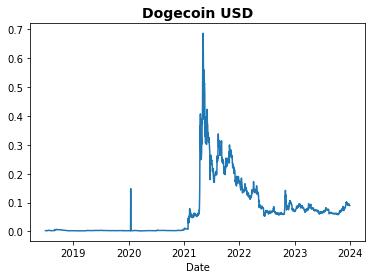

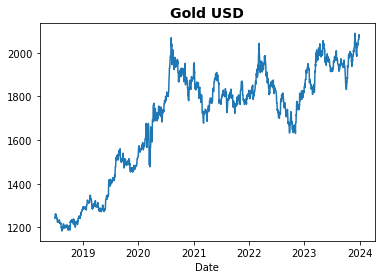

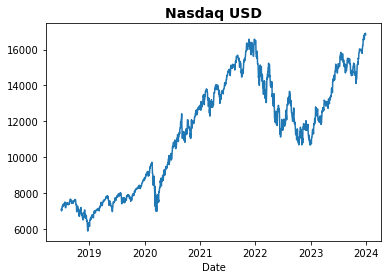

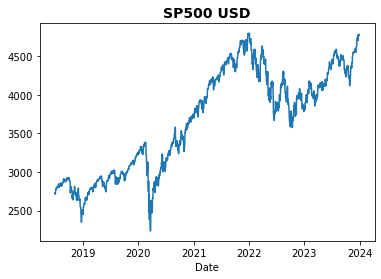

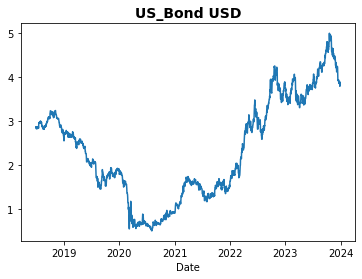

In [115]:
def plot_price_data(name, dataframe):
    plt.plot(dataframe['Date'], dataframe[name])
    plt.xlabel('Date')
    plt.title(f'{name} USD', fontsize=14, fontweight='bold')
    plt.show()

for coin in df_crypto.columns[1:]:
    plot_price_data(coin, df_crypto)

In [72]:
def price_scaling(price_data):
    return (price_data - min(price_data)) / (max(price_data) - min(price_data))

In [116]:
df_crypto

,Date,Bitcoin,Ethereum,Cardano,XRP,Dogecoin,Gold,Nasdaq,SP500,US_Bond
0,2018-07-01,6366.8,452.57,0.1421,0.46226,0.002536,1241.7,7097.82,2726.71,2.871
1,2018-07-02,6619.5,475.70,0.1544,0.49005,0.002735,1241.7,7097.82,2726.71,2.871
2,2018-07-03,6513.5,461.89,0.1498,0.48516,0.002655,1253.5,7014.55,2713.22,2.833
3,2018-07-04,6598.4,467.52,0.1514,0.49194,0.002688,1261.7,7101.05,2736.61,2.833
4,2018-07-05,6546.5,468.47,0.1475,0.47779,0.002614,1261.7,7101.05,2736.61,2.833
...,...,...,...,...,...,...,...,...,...,...
2005,2023-12-27,43446.5,2378.63,0.6335,0.63437,0.093609,2083.4,16906.80,4781.58,3.789
2006,2023-12-28,42581.1,2344.47,0.6160,0.63451,0.091773,2083.5,16898.47,4783.35,3.846
2007,2023-12-29,42072.4,2299.24,0.6083,0.62296,0.090973,2071.8,16825.93,4769.83,3.866
2008,2023-12-30,42136.7,2291.70,0.6011,0.62073,0.089992,NaN,NaN,NaN,NaN


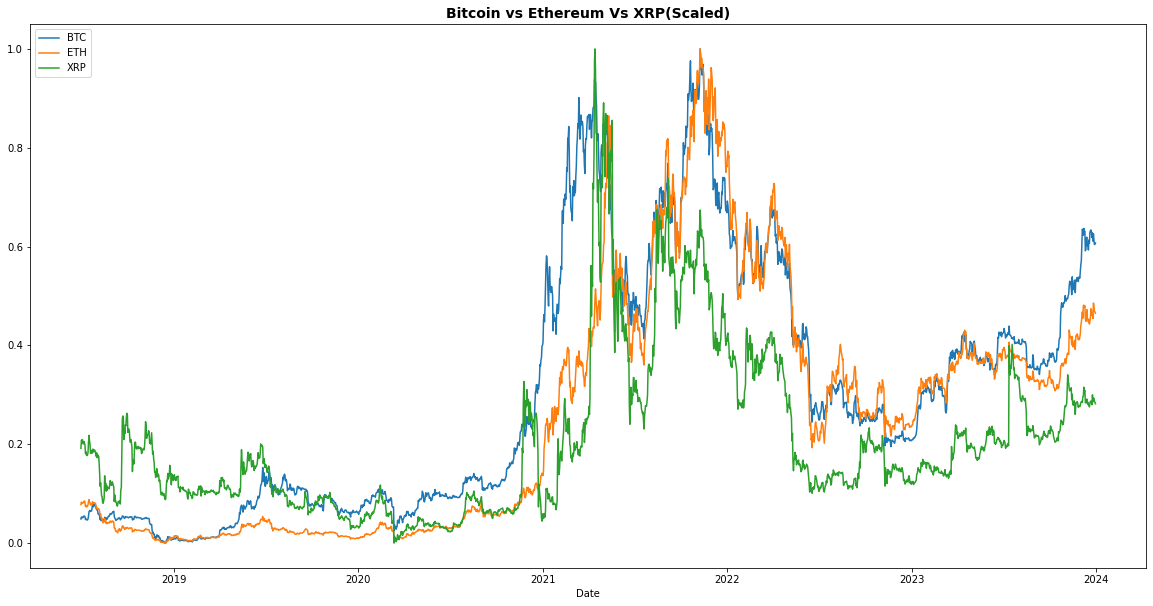

In [127]:
plt.figure(figsize=(20,10))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['Bitcoin']))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['Ethereum']))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['XRP']))
plt.xlabel('Date')
plt.title('Bitcoin vs Ethereum Vs XRP(Scaled)', fontsize=14, fontweight='bold')
plt.legend(['BTC','ETH','XRP'],loc='upper left')
plt.show()

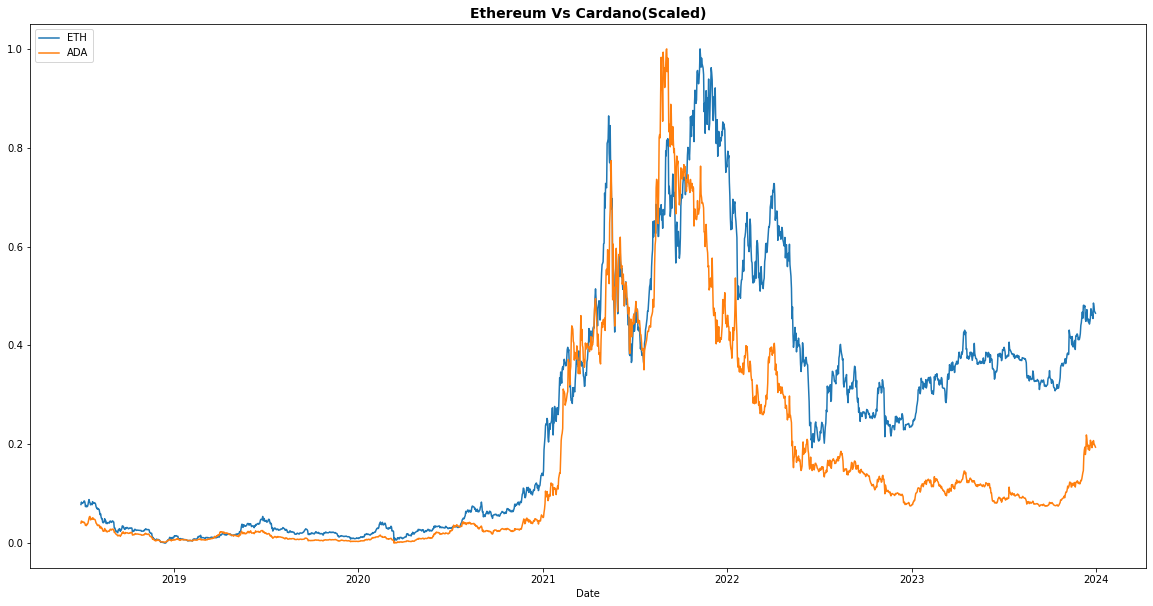

In [129]:
plt.figure(figsize=(20,10))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['Ethereum']))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['Cardano']))
plt.xlabel('Date')
plt.title('Ethereum Vs Cardano(Scaled)', fontsize=14, fontweight='bold')
plt.legend(['ETH','ADA'], loc='upper left')
plt.show()

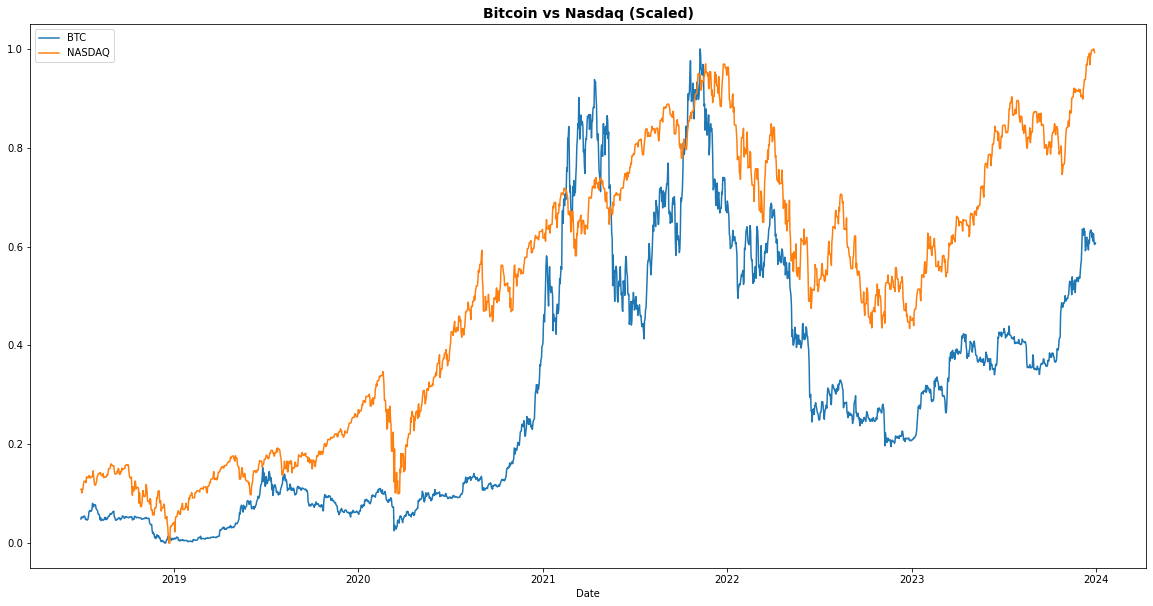

In [131]:
plt.figure(figsize=(20,10))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['Bitcoin']))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['Nasdaq']))
plt.xlabel('Date')
plt.title('Bitcoin vs Nasdaq (Scaled)', fontsize=14, fontweight='bold')
plt.legend(['BTC','NASDAQ'],loc='upper left')
plt.show()

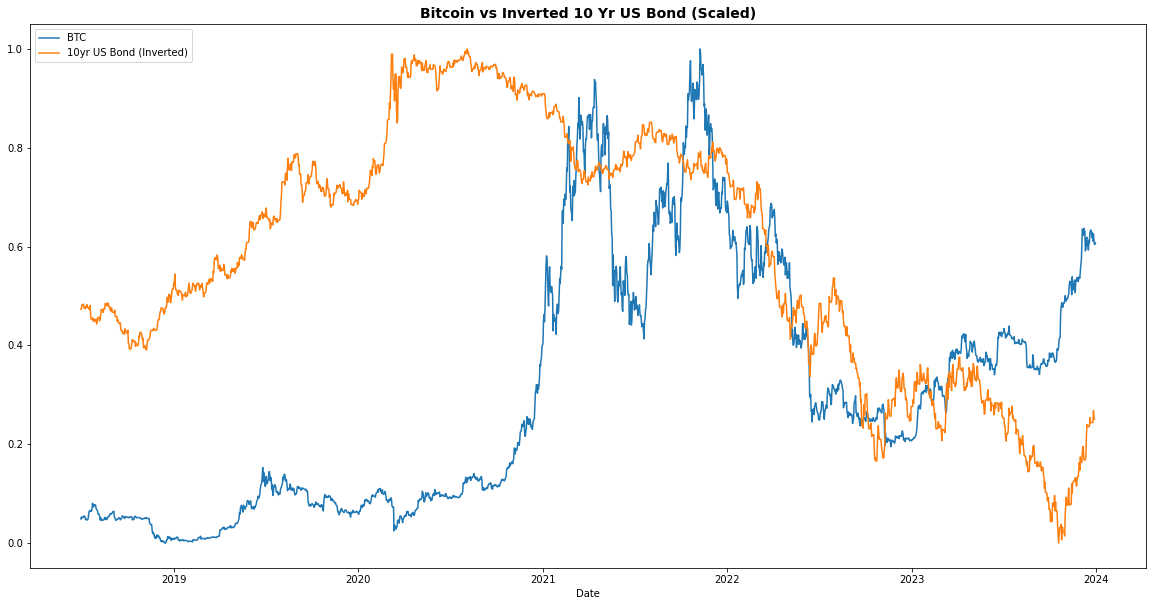

In [133]:
plt.figure(figsize=(20,10))
plt.plot(df_crypto['Date'], price_scaling(df_crypto['Bitcoin']))
plt.plot(df_crypto['Date'], price_scaling(-df_crypto['US_Bond']))
plt.xlabel('Date')
plt.title('Bitcoin vs Inverted 10 Yr US Bond (Scaled)', fontsize=14, fontweight='bold')
plt.legend(['BTC','10yr US Bond (Inverted)'],loc='upper left')
plt.show()

### Bitcoin Valuation

In [7]:
df_bitcoin = pd.read_csv('crypto_price_data.csv', usecols=['Date','Bitcoin'])
df_bitcoin['Date'] = pd.to_datetime(df_bitcoin['Date'])
df_bitcoin.head()

,Date,Bitcoin
0,2018-07-01,6366.8
1,2018-07-02,6619.5
2,2018-07-03,6513.5
3,2018-07-04,6598.4
4,2018-07-05,6546.5


In [8]:
df_bitcoin_ledger = pd.read_csv('bitcoin_ledger_data.csv')
df_bitcoin_ledger = df_bitcoin_ledger.drop(['Unnamed: 0'], axis=1)
df_bitcoin_ledger['date_day'] = pd.to_datetime(df_bitcoin_ledger['date_day'], format='%d/%m/%Y')
df_bitcoin_ledger.head()

,date_day,transactions_count,average_transaction_value,average_fee,address_count
0,2022-04-25,277417,2.915892e+09,4620.82,661219
1,2021-09-12,192691,2.329417e+09,4445.43,425250
2,2022-04-17,207324,1.612004e+09,2576.47,451184
3,2018-10-08,248041,3.340943e+08,6771.46,449776
4,2021-01-07,401744,6.848298e+08,30345.88,738186


In [9]:
df_bitcoin = df_bitcoin.merge(df_bitcoin_ledger, how='left',left_on='Date',right_on='date_day')
df_bitcoin = df_bitcoin.drop(['date_day'], axis=1)

In [10]:
df_bitcoin.head()

,Date,Bitcoin,transactions_count,average_transaction_value,average_fee,address_count
0,2018-07-01,6366.8,156247,549004999.2,10747.66,326089
1,2018-07-02,6619.5,199294,500220458.1,11781.91,444107
2,2018-07-03,6513.5,216747,489852712.5,12873.35,452632
3,2018-07-04,6598.4,206788,429824731.5,10418.66,407761
4,2018-07-05,6546.5,199600,516785126.9,9902.81,359493


In [11]:
# Convert Transaction Value and Fee from Satoshis to Bitcoin
df_bitcoin['average_transaction_value'] = df_bitcoin['average_transaction_value'] / 100000000
df_bitcoin['average_fee'] = df_bitcoin['average_fee'] / 100000000

In [12]:
df_btcreward = pd.read_csv('BitcoinReward.csv')
df_btcreward['DateTime'] = pd.to_datetime(df_btcreward['DateTime'].str[:-5], format='%d/%m/%Y')
df_btcreward = df_btcreward.rename(columns={'DateTime':'Date'})

In [13]:
df_bitcoin = pd.merge(df_bitcoin, df_btcreward, how='left',on='Date')

In [14]:
df_bitcoin.head()

,Date,Bitcoin,transactions_count,average_transaction_value,average_fee,address_count,Block Reward
0,2018-07-01,6366.8,156247,5.490050,0.000107,326089,12.5
1,2018-07-02,6619.5,199294,5.002205,0.000118,444107,12.5
2,2018-07-03,6513.5,216747,4.898527,0.000129,452632,12.5
3,2018-07-04,6598.4,206788,4.298247,0.000104,407761,12.5
4,2018-07-05,6546.5,199600,5.167851,0.000099,359493,12.5


In [15]:
# Replace Outlier
df_bitcoin.loc[df_bitcoin['average_transaction_value'] > 70,'average_transaction_value'] = df_bitcoin['average_transaction_value'].mean()

In [16]:
# Create Daily Network volume variable - Transactions * Average Transaction Value
df_bitcoin['daily_volume'] = df_bitcoin['average_transaction_value'] * df_bitcoin['transactions_count']

In [17]:
# Smooth variables with 7 day rolling average
df_bitcoin['address_count_week_avg'] = df_bitcoin['address_count'].rolling(7).mean()
df_bitcoin['transaction_count_week_avg'] = df_bitcoin['transactions_count'].rolling(7).mean()
df_bitcoin['daily_volume_week_avg'] = df_bitcoin['daily_volume'].rolling(7).mean()

df_bitcoin['address_count_week_avg'] = df_bitcoin['address_count_week_avg'].fillna(method='bfill')
df_bitcoin['transaction_count_week_avg'] = df_bitcoin['transaction_count_week_avg'].fillna(method='bfill')
df_bitcoin['daily_volume_week_avg'] = df_bitcoin['daily_volume_week_avg'].fillna(method='bfill')

In [18]:
df_bitcoin

,Date,Bitcoin,transactions_count,average_transaction_value,average_fee,address_count,Block Reward,daily_volume,address_count_week_avg,transaction_count_week_avg,daily_volume_week_avg
0,2018-07-01,6366.8,156247,5.490050,0.000107,326089,12.50,8.578038e+05,380300.714286,192832.714286,916162.354254
1,2018-07-02,6619.5,199294,5.002205,0.000118,444107,12.50,9.969094e+05,380300.714286,192832.714286,916162.354254
2,2018-07-03,6513.5,216747,4.898527,0.000129,452632,12.50,1.061741e+06,380300.714286,192832.714286,916162.354254
3,2018-07-04,6598.4,206788,4.298247,0.000104,407761,12.50,8.888260e+05,380300.714286,192832.714286,916162.354254
4,2018-07-05,6546.5,199600,5.167851,0.000099,359493,12.50,1.031503e+06,380300.714286,192832.714286,916162.354254
...,...,...,...,...,...,...,...,...,...,...,...
2005,2023-12-27,43446.5,545556,1.409904,0.000492,477666,6.25,7.691814e+05,538165.714286,597228.000000,661848.871457
2006,2023-12-28,42581.1,417180,1.676121,0.000556,531007,6.25,6.992441e+05,544704.714286,572805.571429,656145.179124
2007,2023-12-29,42072.4,581449,1.398849,0.000364,585916,6.25,8.133594e+05,533550.285714,566508.142857,652184.214026
2008,2023-12-30,42136.7,533823,1.165792,0.000495,510504,6.25,6.223268e+05,521966.857143,555843.000000,676210.222033


In [19]:
# EDA - Plot Price vs All scaled values
# Correlation Analysis
# EDA - Plot with NASDAQ500 and SP500

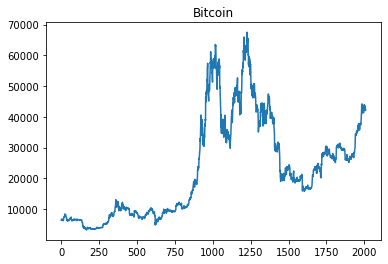

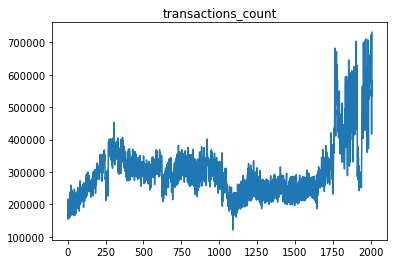

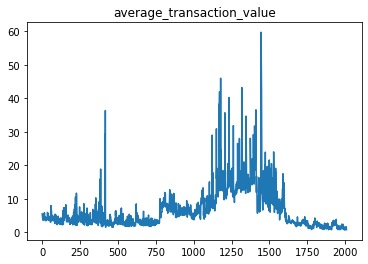

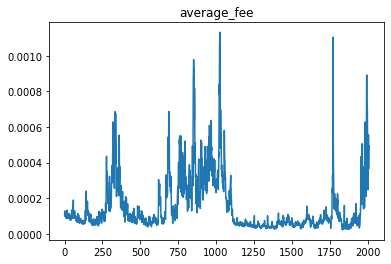

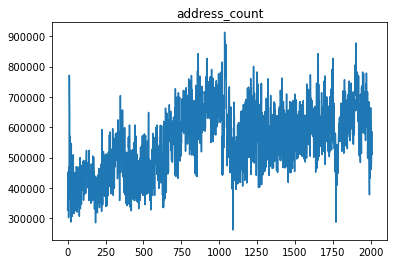

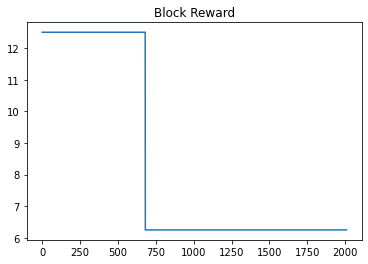

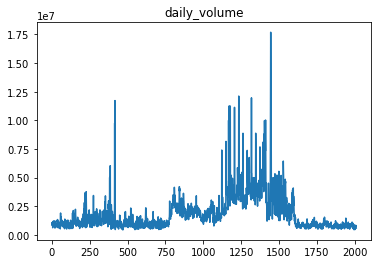

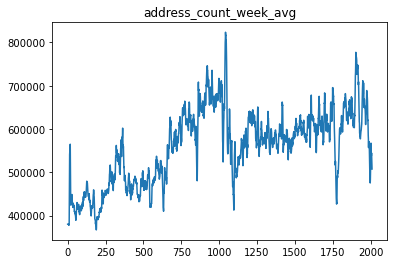

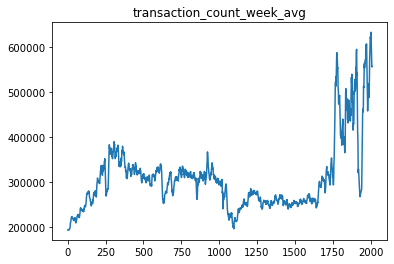

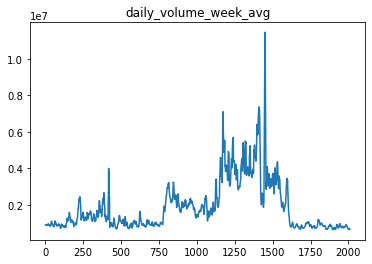

In [20]:
for column in df_bitcoin.columns[1:]:
    df_bitcoin[column].plot()
    plt.title(column)
    plt.show()

In [21]:
def price_scaling(price_data):
    return (price_data - min(price_data)) / (max(price_data) - min(price_data))

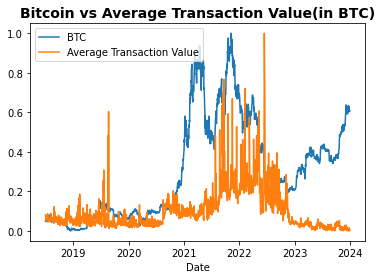

In [22]:
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['Bitcoin']))
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['average_transaction_value']))
plt.xlabel('Date')
plt.title('Bitcoin vs Average Transaction Value(in BTC)', fontsize=14, fontweight='bold')
plt.legend(['BTC','Average Transaction Value'],loc='upper left')
plt.show()

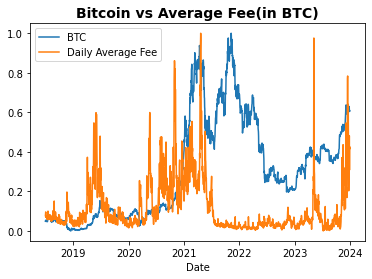

In [23]:
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['Bitcoin']))
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['average_fee']))
plt.xlabel('Date')
plt.title('Bitcoin vs Average Fee(in BTC)', fontsize=14, fontweight='bold')
plt.legend(['BTC','Daily Average Fee'],loc='upper left')
plt.show()

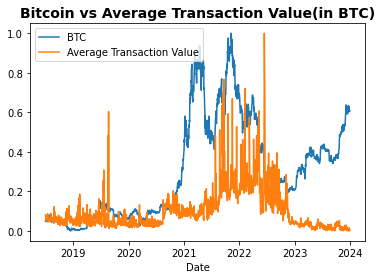

In [24]:
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['Bitcoin']))
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['average_transaction_value']))
plt.xlabel('Date')
plt.title('Bitcoin vs Average Transaction Value(in BTC)', fontsize=14, fontweight='bold')
plt.legend(['BTC','Average Transaction Value'],loc='upper left')
plt.show()

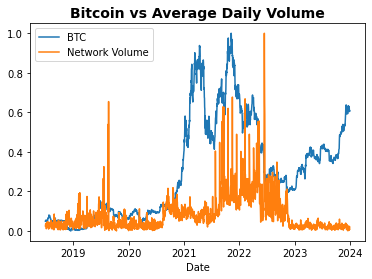

In [25]:
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['Bitcoin']))
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['daily_volume']))
plt.xlabel('Date')
plt.title('Bitcoin vs Average Daily Volume', fontsize=14, fontweight='bold')
plt.legend(['BTC','Network Volume'],loc='upper left')
plt.show()

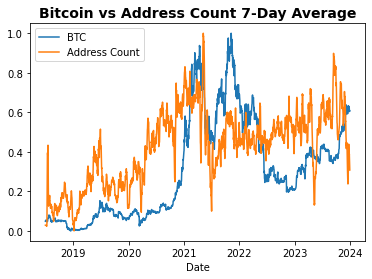

In [26]:
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['Bitcoin']))
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['address_count_week_avg']))
plt.xlabel('Date')
plt.title('Bitcoin vs Address Count 7-Day Average', fontsize=14, fontweight='bold')
plt.legend(['BTC','Address Count'],loc='upper left')
plt.show()

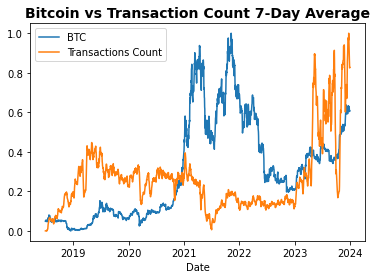

In [27]:
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['Bitcoin']))
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['transaction_count_week_avg']))
plt.xlabel('Date')
plt.title('Bitcoin vs Transaction Count 7-Day Average', fontsize=14, fontweight='bold')
plt.legend(['BTC','Transactions Count'],loc='upper left')
plt.show()

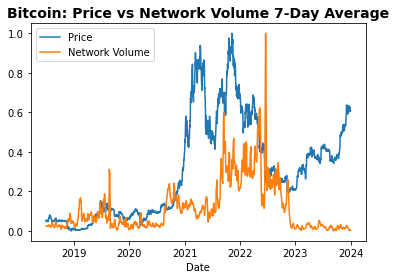

In [28]:
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['Bitcoin']))
plt.plot(df_bitcoin['Date'], price_scaling(df_bitcoin['daily_volume_week_avg']))
plt.xlabel('Date')
plt.title('Bitcoin: Price vs Network Volume 7-Day Average', fontsize=14, fontweight='bold')
plt.legend(['Price','Network Volume'],loc='upper left')
plt.show()

In [29]:
df_supplementary = pd.read_csv('supplementary_financial_data.csv')
df_supplementary['Date'] = pd.to_datetime(df_supplementary['Date'], format='%Y-%m-%d')
df_supplementary.head()

,Date,Gold,Nasdaq,SP500,US_Bond
0,2018-07-02,1241.7,7097.82,2726.71,2.871
1,2018-07-03,1253.5,7014.55,2713.22,2.833
2,2018-07-05,1261.7,7101.05,2736.61,2.833
3,2018-07-06,1255.8,7207.33,2759.82,2.824
4,2018-07-09,1259.6,7276.00,2784.17,2.858


In [30]:
df_bitcoin = df_bitcoin.merge(df_supplementary[['Date','Nasdaq']], how='left', on='Date')

In [31]:
df_bitcoin = df_bitcoin.fillna(method='ffill')

<AxesSubplot:>

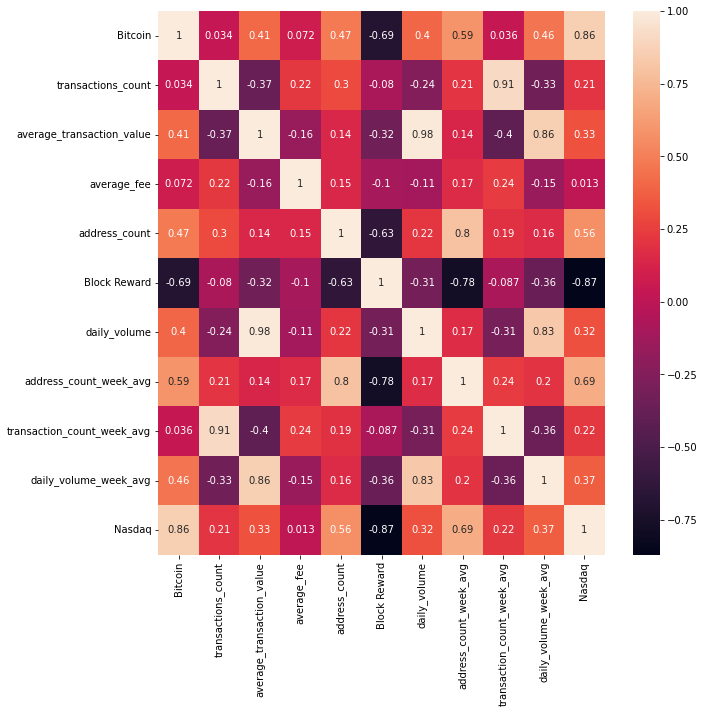

In [32]:
plt.figure(figsize=(10,10))
sns.heatmap(df_bitcoin.corr(), annot=True)

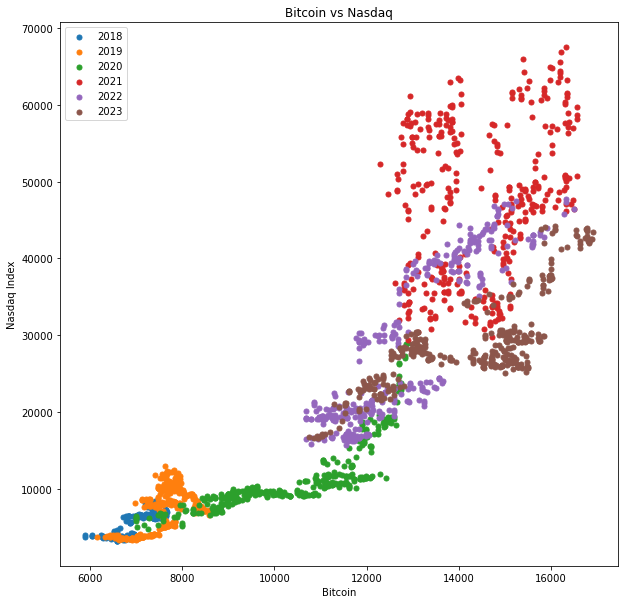

In [33]:
groups = df_bitcoin.groupby(pd.DatetimeIndex(df_bitcoin['Date']).year)
plt.figure(figsize = (10,10))
for name, group in groups:
    plt.scatter(y = group['Bitcoin'], x=group['Nasdaq'], s=25, label=name)
plt.xlabel('Bitcoin')
plt.ylabel('Nasdaq Index')
plt.legend()
plt.title('Bitcoin vs Nasdaq')
plt.show()

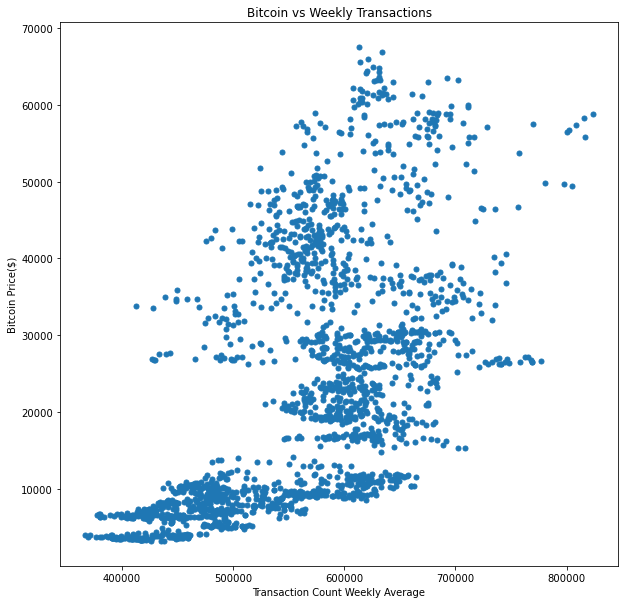

In [34]:
plt.figure(figsize = (10,10))
plt.scatter(y = df_bitcoin['Bitcoin'], x=df_bitcoin['address_count_week_avg'], s=25)
plt.ylabel('Bitcoin Price($)')
plt.xlabel('Transaction Count Weekly Average')
plt.title('Bitcoin vs Weekly Transactions')
plt.show()

In [35]:
df_bitcoin.shape

(2010, 12)

In [87]:
# Training 1/7/2018 to 30/6/2023
# Testing 1/7/2023 to 31/12/23
# Highest Correlation: Nasdaq, address_count_week_avg, average_transaction_value, daily_volume_week_avg
print(df_bitcoin['Date'].max())
print(df_bitcoin['Date'].min())

2023-12-31 00:00:00
2018-07-01 00:00:00


In [113]:
df_bitcoin_train = df_bitcoin[df_bitcoin['Date'] <= '2023-06-30']
df_bitcoin_test = df_bitcoin[df_bitcoin['Date'] > '2023-06-30']
df_bitcoin_train = df_bitcoin_train.fillna(method='bfill')

In [114]:
print(df_bitcoin_train.isna().sum())
print(df_bitcoin_test.isna().sum())

Date                          0
Bitcoin                       0
transactions_count            0
average_transaction_value     0
average_fee                   0
address_count                 0
Block Reward                  0
daily_volume                  0
address_count_week_avg        0
transaction_count_week_avg    0
daily_volume_week_avg         0
Nasdaq                        0
dtype: int64
Date                          0
Bitcoin                       0
transactions_count            0
average_transaction_value     0
average_fee                   0
address_count                 0
Block Reward                  0
daily_volume                  0
address_count_week_avg        0
transaction_count_week_avg    0
daily_volume_week_avg         0
Nasdaq                        0
dtype: int64


In [115]:
print(df_bitcoin_train.shape)
print(df_bitcoin_test.shape)


(1826, 12)
(184, 12)


In [91]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [92]:
def training_test_split(col):
    x_train = df_bitcoin_train[col].values
    x_test = df_bitcoin_test[col].values
    
    x_train = x_train.reshape(-1,1)
    x_test = x_test.reshape(-1,1)
   
    return x_train, x_test

Nasdaq: -3.4439656595217913



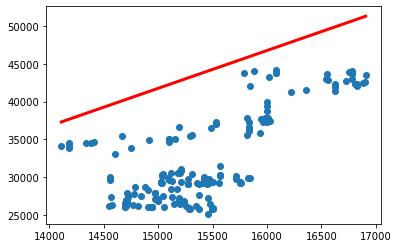

address_count_week_avg: -2.941487023065462



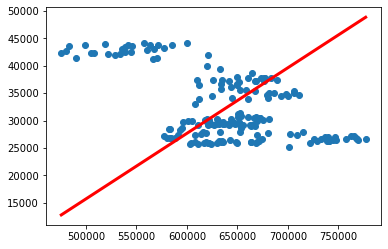

average_transaction_value: -8.777304578345856



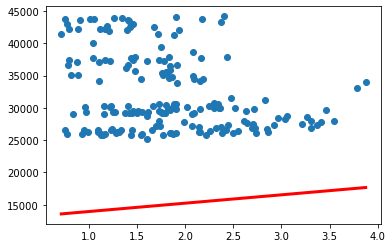

daily_volume_week_avg: -9.2231200817197



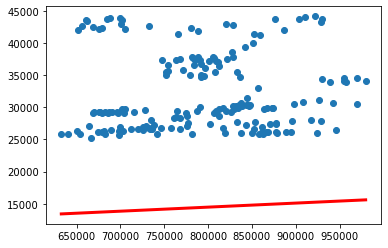

In [93]:
# Simple Linear Regression with Key Variables
y_train = df_bitcoin_train['Bitcoin'].values
y_train = y_train.reshape(-1,1)
y_test = df_bitcoin_test['Bitcoin'].values
y_test = y_test.reshape(-1,1)
results_dict = {'target': pd.Series(y_test.reshape(184,))}

for column in ['Nasdaq', 'address_count_week_avg','average_transaction_value', 'daily_volume_week_avg']:
    x_train, x_test = training_test_split(column)
    
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    print(f'{column}: {reg.score(x_test, y_test)}\n')
    y_pred = reg.predict(x_test)
    ref_str = f'{column}_predictions'
    results_dict[column] = pd.Series(y_pred.reshape(184,))
    
    prediction_space = np.linspace(min(x_test),max(x_test)).reshape(-1,1)
    plt.scatter(x_test, y_test)
    plt.plot(prediction_space, reg.predict(prediction_space), color='red',linewidth=3)
    plt.show()

In [94]:
results_df = pd.DataFrame.from_dict(results_dict, orient='columns')
results_df.head()

,target,Nasdaq,address_count_week_avg,average_transaction_value,daily_volume_week_avg
0,30586.8,42644.005270,33732.834754,15678.469002,15543.334379
1,30617.7,42644.005270,34934.525565,15106.490537,15375.640842
2,31151.3,42791.058871,33771.250034,16306.174871,15273.881925
3,30768.4,42791.058871,34022.008854,15623.006197,15161.667391
4,30512.8,42766.566565,36339.092805,14876.153142,15092.755006


<Figure size 1440x720 with 0 Axes>

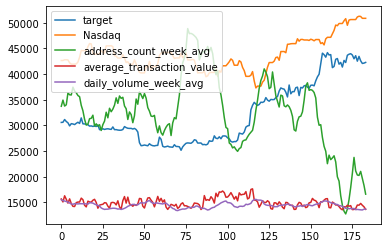

In [95]:
plt.figure(figsize=(20,10))
results_df.plot()
plt.show()

In [102]:
from sklearn.metrics import mean_squared_error
mean_squared_error(results_df['target'], results_df['address_count_week_avg'], squared=False)

11608.579851610628

In [217]:
for column in ['Nasdaq', 'address_count_week_avg','average_transaction_value', 'daily_volume_week_avg']:
    rmse_stat = mean_squared_error(results_df['target'], results_df[column], squared=False)
    print(f'{column}: {rmse_stat}')

Nasdaq: 12326.347008552219
address_count_week_avg: 11608.579851610628
average_transaction_value: 18283.469631743505
daily_volume_week_avg: 18695.658805974315


In [179]:
df_bitcoin_train.head()

,Date,Bitcoin,transactions_count,average_transaction_value,average_fee,address_count,Block Reward,daily_volume,address_count_week_avg,transaction_count_week_avg,daily_volume_week_avg,Nasdaq
0,2018-07-01,6366.8,156247,5.490050,0.000107,326089,12.5,8.578038e+05,380300.714286,192832.714286,916162.354254,7097.82
1,2018-07-02,6619.5,199294,5.002205,0.000118,444107,12.5,9.969094e+05,380300.714286,192832.714286,916162.354254,7097.82
2,2018-07-03,6513.5,216747,4.898527,0.000129,452632,12.5,1.061741e+06,380300.714286,192832.714286,916162.354254,7014.55
3,2018-07-04,6598.4,206788,4.298247,0.000104,407761,12.5,8.888260e+05,380300.714286,192832.714286,916162.354254,7014.55
4,2018-07-05,6546.5,199600,5.167851,0.000099,359493,12.5,1.031503e+06,380300.714286,192832.714286,916162.354254,7101.05


In [204]:
drop_cols = ['transactions_count','address_count', 'average_fee','Date',
             'daily_volume','transaction_count_week_avg','daily_volume_week_avg','Block Reward']
df_bitcoin_all_train = df_bitcoin_train.drop(drop_cols, axis=1)
df_bitcoin_all_test = df_bitcoin_test.drop(drop_cols, axis=1)


In [205]:
df_bitcoin_all_train.head()

,Bitcoin,average_transaction_value,address_count_week_avg,Nasdaq
0,6366.8,5.490050,380300.714286,7097.82
1,6619.5,5.002205,380300.714286,7097.82
2,6513.5,4.898527,380300.714286,7014.55
3,6598.4,4.298247,380300.714286,7014.55
4,6546.5,5.167851,380300.714286,7101.05


In [206]:
y_train = df_bitcoin_all_train['Bitcoin'].values
y_train = y_train.reshape(-1,1)
y_test = df_bitcoin_all_test['Bitcoin'].values
y_test = y_test.reshape(-1,1)

x_train = df_bitcoin_all_train.drop(['Bitcoin'], axis=1).values
x_test = df_bitcoin_all_test.drop(['Bitcoin'], axis=1).values


In [207]:
reg_all = linear_model.LinearRegression()
reg_all.fit(x_train, y_train)
y_pred = reg_all.predict(x_test)
reg_all.score(x_test, y_test)

-2.3197620149873113

In [208]:
mean_squared_error(df_bitcoin_all_test['Bitcoin'],pd.Series(y_pred.reshape(184,)) , squared=False)

10653.75041269341

In [154]:
# Lasso Regression for Feature Selection
from sklearn.linear_model import Lasso

In [176]:
x = df_bitcoin_train.drop(['Bitcoin','transactions_count','address_count', 'average_fee','Date',
             'daily_volume','transaction_count_week_avg'], axis=1).values
y = df_bitcoin_train['Bitcoin'].values
names = df_bitcoin_train.drop(['Bitcoin','transactions_count','address_count', 'average_fee','Date',
             'daily_volume','transaction_count_week_avg'], axis=1).columns
lasso = Lasso(alpha=1.0)
lasso_coef = lasso.fit(x,y).coef_


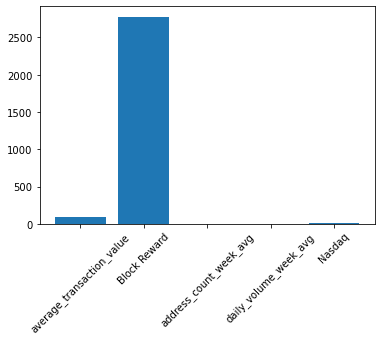

In [177]:
plt.bar(names, lasso_coef)
plt.xticks(rotation=45)
plt.show()

In [210]:
df_bitcoin_train.columns

Index(['Date', 'Bitcoin', 'transactions_count', 'average_transaction_value',
       'average_fee', 'address_count', 'Block Reward', 'daily_volume',
       'address_count_week_avg', 'transaction_count_week_avg',
       'daily_volume_week_avg', 'Nasdaq'],
      dtype='object')

In [211]:
drop_cols = ['transactions_count','address_count', 'average_fee','Date',
             'daily_volume','transaction_count_week_avg','daily_volume_week_avg','address_count_week_avg']
df_bitcoin_all_train = df_bitcoin_train.drop(drop_cols, axis=1)
df_bitcoin_all_test = df_bitcoin_test.drop(drop_cols, axis=1)

In [212]:
df_bitcoin_all_train.columns

Index(['Bitcoin', 'average_transaction_value', 'Block Reward', 'Nasdaq'], dtype='object')

In [213]:
y_train = df_bitcoin_all_train['Bitcoin'].values
y_train = y_train.reshape(-1,1)
y_test = df_bitcoin_all_test['Bitcoin'].values
y_test = y_test.reshape(-1,1)

x_train = df_bitcoin_all_train.drop(['Bitcoin'], axis=1).values
x_test = df_bitcoin_all_test.drop(['Bitcoin'], axis=1).values

In [214]:
reg_all = linear_model.LinearRegression()
reg_all.fit(x_train, y_train)
y_pred = reg_all.predict(x_test)
reg_all.score(x_test, y_test)

-4.730092126910451

In [215]:
mean_squared_error(df_bitcoin_all_test['Bitcoin'],pd.Series(y_pred.reshape(184,)) , squared=False)

13996.835058724186

In [ ]:
# Multiple Regression Results
# average_transaction_value + address_count_week_avg + Nasdaq RMSE: 10653.7504
# average_transaction_value + BLock Reward + Nasdaq: 13996.8350

In [36]:
# Time Series Modelling
df_bitcoin

,Date,Bitcoin,transactions_count,average_transaction_value,average_fee,address_count,Block Reward,daily_volume,address_count_week_avg,transaction_count_week_avg,daily_volume_week_avg,Nasdaq
0,2018-07-01,6366.8,156247,5.490050,0.000107,326089,12.50,8.578038e+05,380300.714286,192832.714286,916162.354254,NaN
1,2018-07-02,6619.5,199294,5.002205,0.000118,444107,12.50,9.969094e+05,380300.714286,192832.714286,916162.354254,7097.82
2,2018-07-03,6513.5,216747,4.898527,0.000129,452632,12.50,1.061741e+06,380300.714286,192832.714286,916162.354254,7014.55
3,2018-07-04,6598.4,206788,4.298247,0.000104,407761,12.50,8.888260e+05,380300.714286,192832.714286,916162.354254,7014.55
4,2018-07-05,6546.5,199600,5.167851,0.000099,359493,12.50,1.031503e+06,380300.714286,192832.714286,916162.354254,7101.05
...,...,...,...,...,...,...,...,...,...,...,...,...
2005,2023-12-27,43446.5,545556,1.409904,0.000492,477666,6.25,7.691814e+05,538165.714286,597228.000000,661848.871457,16906.80
2006,2023-12-28,42581.1,417180,1.676121,0.000556,531007,6.25,6.992441e+05,544704.714286,572805.571429,656145.179124,16898.47
2007,2023-12-29,42072.4,581449,1.398849,0.000364,585916,6.25,8.133594e+05,533550.285714,566508.142857,652184.214026,16825.93
2008,2023-12-30,42136.7,533823,1.165792,0.000495,510504,6.25,6.223268e+05,521966.857143,555843.000000,676210.222033,16825.93


In [37]:
price_data = df_bitcoin[['Date','Bitcoin']].set_index('Date')

In [38]:
price_data

,Bitcoin
Date,
2018-07-01,6366.8
2018-07-02,6619.5
2018-07-03,6513.5
2018-07-04,6598.4
2018-07-05,6546.5
...,...
2023-12-27,43446.5
2023-12-28,42581.1
2023-12-29,42072.4


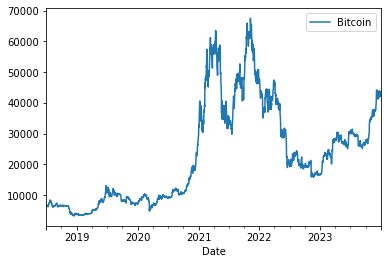

In [39]:
price_data.plot()
plt.show()

In [40]:
price_train = price_data.loc[:'2023-06-30']
price_test = price_data.loc['2023-07-1':]

In [41]:
price_test.head()

,Bitcoin
Date,
2023-07-01,30586.8
2023-07-02,30617.7
2023-07-03,31151.3
2023-07-04,30768.4
2023-07-05,30512.8


In [42]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(price_data)
print(results)

(-1.3464153126557878, 0.6076790013525546, 24, 1985, {'1%': -3.433648628001351, '5%': -2.8629971502062155, '10%': -2.5675457254979093}, 33023.57768977499)


<AxesSubplot:xlabel='Date'>

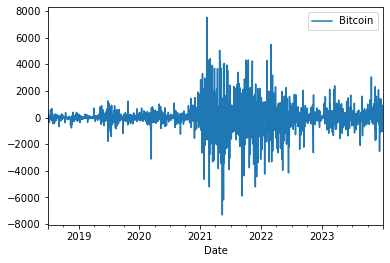

In [43]:
price_data_stationary = price_data.diff().dropna()
price_data_stationary.plot()

In [47]:
adfuller(price_data_stationary)

(-7.704765258434159,
 1.310508029384703e-11,
 26,
 1982,
 {'1%': -3.4336536273681078,
  '5%': -2.862999357426174,
  '10%': -2.567546900734257},
 33007.60182365842)

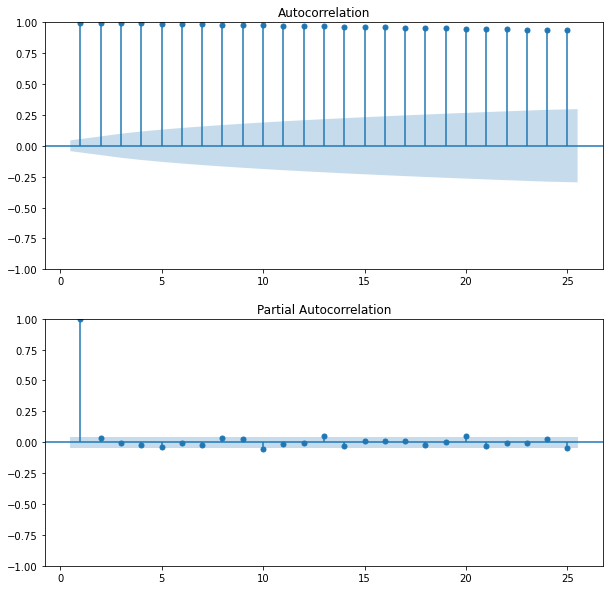

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
plot_acf(price_data, lags=25, zero=False, ax=ax1)
plot_pacf(price_data, lags=25, zero=False, ax=ax2)
plt.show()

In [54]:
from statsmodels.tsa.arima.model import ARIMA

In [56]:
model = ARIMA(price_data, order=(1,0,0))
res= model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                Bitcoin   No. Observations:                 2010
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -16729.910
Date:                Sat, 27 Jan 2024   AIC                          33465.820
Time:                        20:13:21   BIC                          33482.638
Sample:                    07-01-2018   HQIC                         33471.994
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.288e+04   1.34e+04      1.703      0.088   -3446.481    4.92e+04
ar.L1          0.9982      0.001    781.666      0.000       0.996       1.001
sigma2      9.905e+05   1.31e+04     75.770      0.0

C:\Users\white\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\white\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\white\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [63]:
df_bitcoin['Nasdaq'] = df_bitcoin['Nasdaq'].fillna(method='bfill')

In [73]:
price_data_exog = df_bitcoin[['Date','Bitcoin','Nasdaq','address_count_week_avg']]
price_data_exog = price_data_exog.set_index('Date')

In [75]:
model = ARIMA(price_data_exog['Bitcoin'], order=(1,0,0), exog=price_data_exog['Nasdaq'])
res= model.fit()
print(res.summary())

C:\Users\white\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\white\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\white\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Bitcoin   No. Observations:                 2010
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -16648.542
Date:                Sat, 27 Jan 2024   AIC                          33305.085
Time:                        20:21:52   BIC                          33327.508
Sample:                    07-01-2018   HQIC                         33313.316
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.909e+04   2.41e-09  -1.21e+13      0.000   -2.91e+04   -2.91e+04
Nasdaq         1.9036      0.116     16.471      0.000       1.677       2.130
ar.L1          1.0000   8.53e-05   1.17e+04      0.0

In [76]:
forecast = res.get_prediction(start=-60)

In [80]:
dates = price_data_exog.index[-60:]
dates

DatetimeIndex(['2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05',
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-18', '2023-11-19', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
               '2023-11-26', '2023-11-27', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01', '2023-12-02', '2023-12-03',
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
               '2023-12-08', '2023-12-09', '2023-12-10', '2023-12-11',
               '2023-12-12', '2023-12-13', '2023-12-14', '2023-12-15',
               '2023-12-16', '2023-12-17', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-23',
               '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27',
      

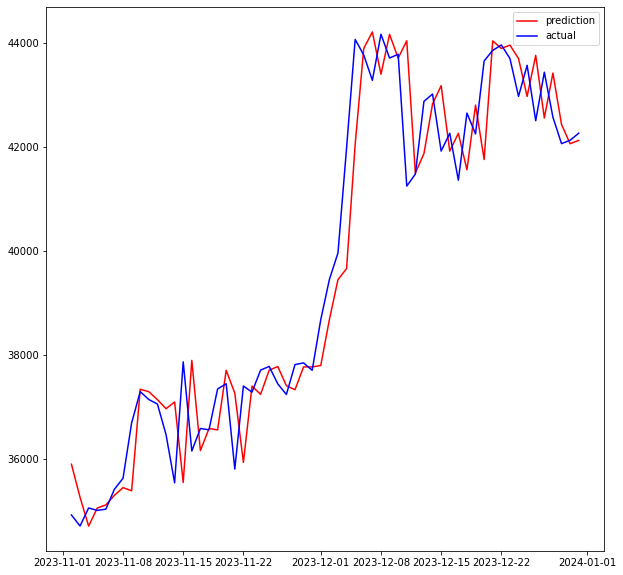

In [88]:
plt.figure(figsize=(10,10))

plt.plot(price_data_exog.index[-60:], forecast.predicted_mean, color='red', label='prediction' )
plt.plot(price_data_exog.index[-60:], price_data_exog['Bitcoin'][-60:], color='blue', label='actual')
plt.legend()
plt.show()